# Project 1 - Aurèle Bohbot, Quentin Guilhot, Yanis Tournier

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import plotly.express as px
from numpy import where
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.metrics import r2_score
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_regression
from sklearn.tree import ExtraTreeRegressor
import math as m
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.covariance import EllipticEnvelope

In [156]:
X = pd.read_csv('X_train.csv').drop(columns=['id'])
Xt = pd.read_csv('X_test.csv')
y = pd.read_csv('y_train.csv')
to_drop = ['x104', 'x129', 'x489', 'x530']
X = X.drop(columns=to_drop)
y = y.drop(columns=['id'])

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [158]:
print(X_train.info())
X_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 806 to 1126
Columns: 828 entries, x0 to x831
dtypes: float64(828)
memory usage: 6.1 MB
None


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
516,17491.883896,11814.566421,3963.668795,112425.428257,107.775865,88.847406,11811.014207,10854.945186,NaN,9.488575,...,NaN,15246.001490,767.001978,109.832288,106.499789,2313.057699,2.494429,1531.420265,1055.198322,10699.298875
133,13442.854883,9357.072928,3240.367202,98474.212219,107.177830,93.746738,10681.657500,10603.795925,10705.66276,9.665457,...,10935.261027,12932.078655,943.092938,109.936436,107.697235,2364.022402,2.931867,1380.253912,1016.360059,9791.547794
755,16787.376593,11570.558424,3062.042205,99216.564689,105.141292,100.484866,9587.894395,10289.330659,10676.59887,9.567970,...,10969.551579,12255.027270,564.087996,108.795606,102.125508,2338.014409,2.499915,1249.915595,1096.234371,10806.054658


### Handling outliers

In [122]:
def detection(df,features):
    outlier_indices=[]
    
    for c in features:
        Q1, Q3 = np.percentile(df[c],25), np.percentile(df[c],75)
        
        #IQR calculation
        IQR = Q3 - Q1
        outlier_step = IQR * 1.5
        lower_range = Q1 - (outlier_step)
        upper_range = Q3 + (outlier_step)
        
        #Outlier detection                                    #Outlier indexes
        outlier_list_col=df[  (df[c] < lower_range) | (df[c] > upper_range)  ].index
        
        #Store indexes
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices=Counter(outlier_indices)
    # number of outliers
    # If we have more then 2 outliers in a sample, this sample ll be drop
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2 )
    #we are taking indexes
    
    return multiple_outliers

In [123]:
outliers = detection(X_train, X_train.columns)
X_train=X_train.drop(outliers,axis=0).reset_index(drop = True)
X_train.shape

(969, 828)

### Handling missing values 

For the moment, we replace the missing values by the column's median. Depending on the results, we might implement a knn algorithm.

In [159]:
y_test = y_test.fillna(y_test.median())
y_train = y_train.fillna(y_train.median())
X_test = X_test.fillna(X_test.median())

X_train_filled = X_train.fillna(X_train.median())
X_test_filled = X_test.fillna(X_train.median())


In [160]:
X_train_norm = X_train_filled.copy()
for col in X_train_filled.columns:
    X_train_norm[col] = (X_train_filled[col] - X_train_filled[col].mean()) / m.sqrt(X_train_filled[col].var())
X_train_norm

X_test_norm = X_test_filled.copy()
for col in X_test_filled.columns:
    X_test_norm[col] = (X_test_filled[col] - X_test_filled[col].mean()) / m.sqrt(X_test_filled[col].var())
X_test_norm

## should we normalize y too ?

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
801,1.359533,0.459014,0.339587,-0.194593,0.783548,1.033031,-0.054079,1.386708,1.419838,0.316343,...,-0.934455,0.730277,-0.743350,-0.342046,0.945600,2.282991,-0.528466,-0.454877,1.485537,0.002413
677,-0.148333,-0.131357,0.665774,-1.069432,1.133581,1.811608,0.950913,-0.900671,0.422283,1.354028,...,0.814070,0.308782,-1.341874,-0.674404,-1.406581,0.312330,-0.009769,-0.046611,-1.079061,0.862273
43,-0.273613,1.601598,-0.809951,-0.010533,1.514877,-0.005275,0.570904,-1.385937,-0.046404,1.062219,...,-0.981165,-1.688710,-0.667807,-0.614756,1.109218,-1.782454,-1.193961,-0.025684,1.427604,-0.876229
990,-0.460091,-0.217644,1.313331,-0.918573,-1.276381,-0.005275,1.370343,-0.108825,-1.728645,1.053114,...,-0.613586,-0.933824,-0.006646,-1.377137,-0.105661,-0.598885,-0.130783,-0.327974,-0.211967,0.720824
70,1.030626,0.945782,1.528852,-0.120766,0.578191,-0.378145,-1.452431,-1.100144,1.654622,1.029604,...,-0.005430,1.462694,0.068921,0.723125,0.204150,0.737810,-0.130783,1.392817,1.441607,-1.205046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,0.580896,-0.131357,0.217757,1.232651,-0.875616,-1.445223,0.171942,-0.095679,0.781302,-0.980250,...,-0.327102,-0.357407,0.427206,0.614293,-0.341914,-0.010265,1.006951,0.285387,1.646663,-0.164958
673,-0.148333,0.154172,-1.454732,-1.482054,-0.343430,-0.449199,1.558752,1.457223,1.489332,0.686624,...,0.631523,0.309821,1.032625,-1.221606,0.337297,-0.754033,0.459332,0.915614,1.020814,0.323661
708,0.715143,-0.272410,2.109801,0.196859,-0.051390,-1.229249,-1.003329,0.018998,-0.046404,0.699176,...,-0.545884,0.109474,1.411440,0.470524,-1.182927,-1.381369,-1.632139,1.810377,0.674904,0.122216
367,-0.320823,-0.680830,0.435163,-0.558359,0.288287,0.266746,1.361249,-1.190624,-1.112909,-0.061817,...,1.782686,0.552893,-0.357741,-0.618208,0.101780,0.015179,-0.130783,0.410358,-0.005904,-0.925360


### Handling feature selections

In [213]:
## Univariate feature selection with the highest variance
select_feature = SelectKBest(f_regression, k=(10)).fit(X_train_norm, y_train)
X_train_new = select_feature.transform(X_train_norm)
X_test_new = select_feature.transform(X_test_norm)
X_train_new.shape


/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(969, 10)

In [ ]:
## Feature selection with PCA

pca = PCA(n_components=100)
pca.fit(X_train_norm,y_train)
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [150]:
## Feature selection/ranking with recursive feature elimination

X_train_RFE = X_train_norm.values
X_test_RFE = X_test_norm.values
y_train_RFE = y_train.values.reshape(-1)
clf_rf_3 = SVR(kernel="linear")      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=20, step=1)
rfe = rfe.fit(X_train_RFE, y_train_RFE)

KeyboardInterrupt: 

<AxesSubplot:>

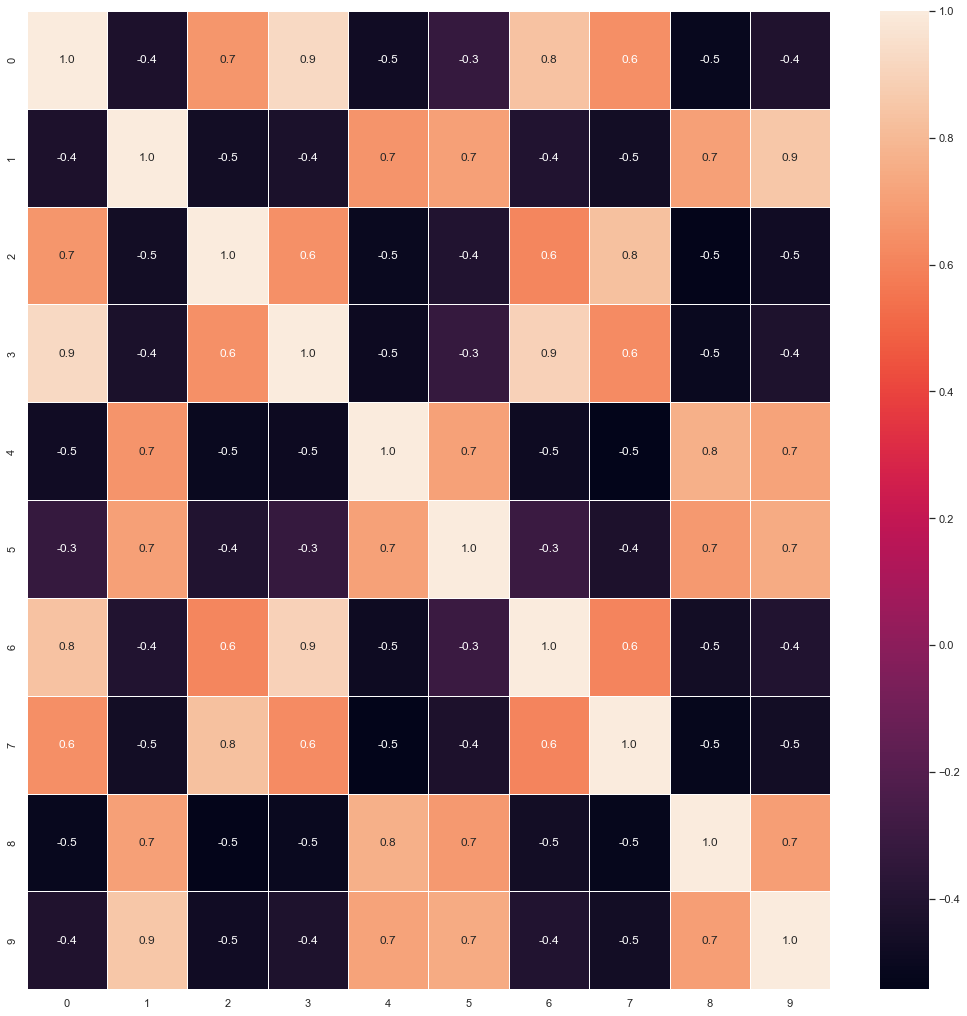

In [214]:
### Feature visualization
# correlation map
X_dtf = pd.DataFrame(X_train_new)
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X_dtf.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

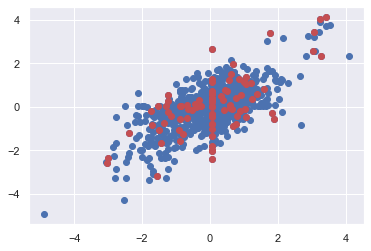

(97, 10) (969, 10)


(array([ 13,  17,  30,  33,  52,  55,  61,  62,  86, 100, 110, 111, 113,
        118, 130, 133, 139, 159, 177, 185, 203, 212, 213, 221, 231, 245,
        250, 252, 267, 270, 271, 273, 280, 310, 319, 329, 337, 347, 349,
        362, 385, 396, 397, 401, 404, 417, 419, 437, 442, 446, 448, 458,
        486, 500, 511, 515, 542, 547, 587, 595, 611, 616, 620, 631, 633,
        671, 682, 703, 705, 709, 725, 751, 755, 756, 789, 790, 794, 813,
        815, 821, 825, 846, 861, 863, 866, 870, 872, 882, 885, 913, 934,
        952, 953, 954, 959, 962, 965]),)

In [220]:
## Outlier detection with multivariate technique: gaussian mixture model
elenv = EllipticEnvelope(contamination=0.1)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,2])
plt.scatter(values_anom[:,0],values_anom[:,2], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)
anom_index

In [ ]:
X_anom_dtf = pd.DataFrame(values_anom)
sns.set()
sns.pairplot(X_dtf, size = 2.5)
sns.pairplot(X_anom_dtf, size = 2.5)
plt.show();

In [217]:
model = LinearRegression()
model.fit(X_train_new, y_train)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

0.2389649124709835

In [218]:
regr = RandomForestRegressor(max_depth=20, random_state=0)
regr.fit(X_train_new, y_train)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score

/var/folders/xz/2x_7tl010yn5bqd9lf1tsr3m0000gn/T/ipykernel_68857/4244690101.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train_new, y_train)


0.43816056013667326